In [ ]:
!pip install -U -qq torch torchvision diffusers transformers accelerate DeepCache tgate pytorch-fid peft scikit-image cython

# CLIP
!pip install -U -qq git+https://github.com/openai/CLIP.git

# coco API
!pip install -U -qq "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"

In [1]:
%reload_ext autoreload
%autoreload 2

# Load model

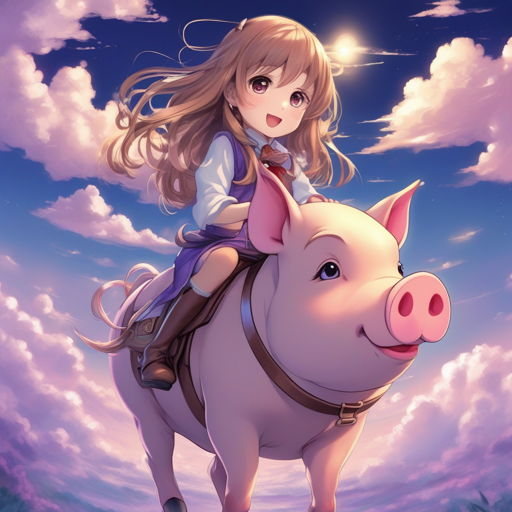

In [9]:
from diffusers import StableDiffusionXLPipeline, DPMSolverMultistepScheduler, AutoencoderTiny  
from utils import SDEvaluator
import torch

device = torch.device('mps')

base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = StableDiffusionXLPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16).to(device)
# pipe.vae = AutoencoderTiny.from_pretrained("madebyollin/taesdxl", torch_dtype=torch.float16).to(device)
# pipe.enable_freeu(s1=0.9, s2=0.2, b1=1.3, b2=1.4)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
sd = SDEvaluator(pipe, device=device)

sd.generate('little anime girl, riding on a pig, clear eyes, purple clouds, beautiful face, long hair, clear eyes, holding hands with a pig', 
            negative_prompt = 'deformed hands, mutated hands, ugly face, bad anatomy, low quality, no legs, bad, bad legs',
            num_inference_steps=26, 
            generator=torch.Generator(device=device).manual_seed(0),
            width=512, height=512,
            )

# Load COCO data

In [ ]:
from utils import SDEvaluator, download_COCO, validate_coco_images
PROMPTS = download_COCO(N_ann=512, N_fid=4096)
validate_coco_images()

# Check Tflops, CLIP & FID

In [ ]:
from tqdm import tqdm
import gc, torch, os
from joblib import Parallel, delayed
from diffusers import PNDMScheduler, DPMSolverMultistepScheduler, TCDScheduler, UniPCMultistepScheduler, EulerDiscreteScheduler
# import multiprocessing
# multiprocessing.set_start_method('spawn', force=True)

NFE = list(range(4, 26))
SCHEDULERS = [
  (DPMSolverMultistepScheduler, 'DPMSolver'),
  (EulerDiscreteScheduler, 'Euler'),
  (UniPCMultistepScheduler, 'UniPC'),
  (PNDMScheduler, 'PNDM'),
  (TCDScheduler, 'TCD'),
]

NUM_GPU = 4

def run_sd_on_device(device, scheduler_pair):
  scheduler, scheduler_name = scheduler_pair

  base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
  pipe = StableDiffusionXLPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16).to(device)
  pipe.vae = AutoencoderTiny.from_pretrained("madebyollin/taesdxl", torch_dtype=torch.float16).to(device)
  pipe.scheduler = scheduler.from_config(pipe.scheduler.config)
  
  kwargs = {}
  if scheduler_name == 'TCD':
    tcd_lora_id = "h1t/TCD-SDXL-LoRA"
    pipe.load_lora_weights(tcd_lora_id)
    pipe.fuse_lora()
    kwargs['eta'] = 0.2
  
  sd = SDEvaluator(pipe, device=device)

  path_gen_img = os.path.join('generated_images', scheduler_name)
  os.makedirs(path_gen_img, exist_ok=True)

  Tflops, CLIP_scores, FID_scores = [], [], []
  for nfe in NFE:
    kwargs['num_inference_steps'] = nfe
    Tflops.append(sd.Tflops(**kwargs))
    CLIP_scores.append(sd.CLIP(PROMPTS, **kwargs))
    # FID_scores.append(sd.FID(PROMPTS, path_gen_img=path_gen_img, **kwargs)) # too slow
    
  return scheduler_name, Tflops, CLIP_scores, FID_scores


RESULTS = []
for i in tqdm(range(0, len(SCHEDULERS), NUM_GPU)):
  batch_schedulers = SCHEDULERS[i:i + NUM_GPU]
  devices = [f'cuda:{i % NUM_GPU}' for i in range(len(batch_schedulers))]
  
  torch.cuda.empty_cache()
  gc.collect()

  results_batch = Parallel(n_jobs=len(devices), backend='loky', timeout=99999)(
    delayed(run_sd_on_device)(device, scheduler) for device, scheduler in zip(devices, batch_schedulers)
    )
  RESULTS.extend(results_batch)